# **Deep Neural Network**

## **Data**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler #전처리 라이브러리에 정규화 함수가 내장되어있다.

### **Goal**  
Boston Housing 데이터셋을 이용해, 주택 가격(TARGET)을 예측하는 회귀 문제를 DNN 구조로 학습시키기

In [4]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
raw_df=pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
data=np.hstack([raw_df.values[::2, :], raw_df.values[1::2,:2]])
target=raw_df.values[1::2,2]

feature_names= ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
df=pd.DataFrame(data, columns=feature_names)
df["TARGET"] = target
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


표준 스케일러로 정규화를 시켜준다.
정규화를 통해 각 특성의 단위 차이로 인한 학습의 불균형을 방지한다.

In [28]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:,:-1] = scaler.transform(df.values[:, :-1]).round(4) #정답 컬럼 제외

df.tail()

,y,y_hat
501,-0.0145,22.345110
502,-0.2104,22.574284
503,0.1488,25.860861
504,-0.0580,24.448441
505,-1.1572,23.155340


## **Source Code**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**1. 데이터 준비 및 입출력 데이터 정의**

In [7]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

**2. 하이퍼 파라미터 정의**

In [15]:
epochs = 200000
learning_rate = 1e-4
print_interval = 10000

**3-1. DNN 정의(모델 클래스 직접 정의)**

- 선형 계층들은 각각 다른 가중치 파라미터를 가지게 되므로 다른 객체로 선언
- 비선형 활성 함수의 경우에는 학습되는 파라미터를 갖지 않기 때문에 모든 계층에서 동일하게 동작하므로, 한 개만 선언

In [9]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__()

        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, 3)
        self.linear4 = nn.Linear(3, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(x))
        h = self.act(self.linear3(x))
        y = self.linear4(h)

        return y

In [10]:
model = MyModel(x.size(-1), y.size(-1))
print(model)

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=3, bias=True)
  (linear4): Linear(in_features=3, out_features=3, bias=True)
  (act): ReLU()
)


**3-2. DNN 정의(nn.Sequential 클래스 활용)**

- MyModel 클래스와 달리 Sequential이 각 층을 순서대로 담는 리스트형 구조이기 때문에, (Leaky)ReLU 인스턴스를 명시적으로 추가해야한다. 

In [25]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 3), #linear 1
    nn.LeakyReLU(),
    nn.Linear(3, 3), # linear 2
    nn.LeakyReLU(),
    nn.Linear(3, 3), # linear 3
    nn.LeakyReLU(),
    nn.Linear(3, 3), # linear 4
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)) # 해당 문제에서 원하는 문제가 선형적이므로, 최종 계층은 선형 계층으로 설정한다.
)

print(model)

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


**4. 최적화 알고리즘 설정**

In [16]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

**5. 에폭 루프 설정**

In [20]:
for i in range(epochs):
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % print_interval == 0:
        print("Epoch %d : loss=%.4e" % (i+1, loss))

C:\Users\user\AppData\Local\Temp\ipykernel_5860\2952659078.py:9: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  print("Epoch %d : loss=%.4e" % (i+1, loss))


Epoch 10000 : loss=5.4492e+01
Epoch 20000 : loss=4.2771e+01
Epoch 30000 : loss=3.6336e+01
Epoch 40000 : loss=3.3638e+01
Epoch 50000 : loss=2.5353e+01
Epoch 60000 : loss=2.6315e+01
Epoch 70000 : loss=1.7883e+01
Epoch 80000 : loss=1.7206e+01
Epoch 90000 : loss=1.6047e+01
Epoch 100000 : loss=1.5723e+01
Epoch 110000 : loss=1.5343e+01
Epoch 120000 : loss=1.5316e+01
Epoch 130000 : loss=1.5062e+01
Epoch 140000 : loss=1.4492e+01
Epoch 150000 : loss=1.4447e+01
Epoch 160000 : loss=1.3740e+01
Epoch 170000 : loss=1.3694e+01
Epoch 180000 : loss=1.2409e+01
Epoch 190000 : loss=1.3847e+01
Epoch 200000 : loss=1.2970e+01


**6. 시각화**

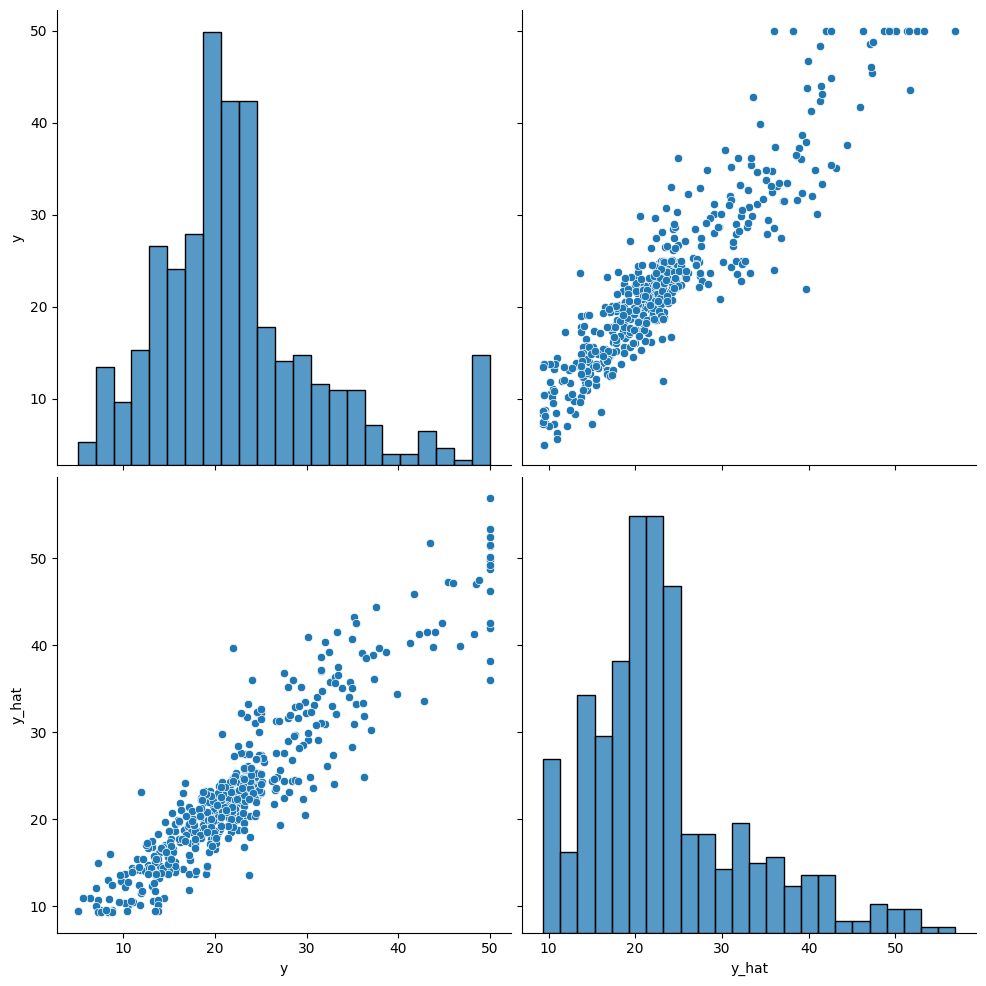

In [23]:
df = pd.DataFrame(
    torch.cat([y, y_hat], dim=1).detach().numpy(),
    columns=["y", "y_hat"]
)

sns.pairplot(df, height=5)
plt.show()